## Load Libraries

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import causalimpact as ci

import umap.umap_ as umap
import hdbscan

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

## Load Crash Data

In [2]:
# load crash data
crashes_df = pd.read_csv('/home/gopherguy14/datasets/US_Accidents_Dec20.csv')
# shape
crashes_df.shape

(4232541, 49)

In [3]:
# convert start_time to datetime type
crashes_df['Start_Time'] = crashes_df.Start_Time.astype('datetime64[ns]')
# create date column
crashes_df['Start_Date'] = crashes_df.Start_Time.dt.date
# create subset of data to show to be one year prior to March 12th, 2020 and
# up to December 31st, 2020 
crashes_subset = crashes_df[ ( crashes_df['Start_Time'] > '2019-03-01' ) & ( crashes_df['Start_Time'] < '2021-01-01') ][['ID','Start_Date','County','State']]
# remove duplicates
crashes_subset = crashes_subset.drop_duplicates(subset='ID')
# perform the aggregation
crashes_subset = crashes_subset.groupby(['Start_Date','County','State']).agg({'ID':'count'})
crashes_subset = crashes_subset.reset_index()

## Line plot with Pandas
This shows something unexpected! there are up to 10,000 crashes per day towards the end of 2020, much higher than what appears to be a steady-state in the beginning. When did it all change? After some inspection, it seems that June 27th, 2020 is the beginning of a strong decrease in crashes per day. 

In [4]:
data_for_plot = crashes_subset[['Start_Date','ID']].groupby(['Start_Date']).agg({'ID' : 'sum'})
data_for_plot = data_for_plot.reset_index()
data_for_plot['index1'] = data_for_plot.index
data_for_plot.Start_Date.astype("datetime64[ns]")
data_for_plot = data_for_plot.sort_values('Start_Date')

<AxesSubplot:xlabel='index1'>

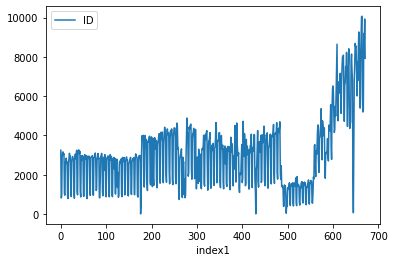

In [5]:
data_for_plot.plot.line('index1','ID')

In [6]:
# import datetime as dt
# data_for_plot[ ( data_for_plot['index1'] > 450 ) & ( data_for_plot['ID'] > 3000) & ( data_for_plot['index1'] < 500)].head(50)
# data_for_plot[ data_for_plot['Start_Date'] > dt.date(2020,6,25)].head(20)
# the end of the pre period should really be june 29th, 2020
# the beginning of the post period should really be June 30th, 2020

In [7]:
data_for_plot[ data_for_plot['Start_Date'] == dt.date(2020,6,30)]

,Start_Date,ID,index1
487,2020-06-30,1383,487


## Causal Impact
We can investigate the impact of the change in crashes by using pycausalimpact -- which is a port of the incredible causalimpact pakcage for R. It even generates a report! Here we specify everything before June 27th, 2020 as the 'pre' period and everything after ( and including ) June 27th, 2020 as the 'post' period

/home/gopherguy14/anaconda3/envs/xgboost/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3893.26            720254.0
Prediction (s.d.)         3379.85 (172.69)   625272.72 (31948.22)
95% CI                    [3031.46, 3708.4]  [560820.05, 686054.79]

Absolute effect (s.d.)    513.41 (172.69)    94981.28 (31948.22)
95% CI                    [184.86, 861.81]   [34199.21, 159433.95]

Relative effect (s.d.)    15.19% (5.11%)     15.19% (5.11%)
95% CI                    [5.47%, 25.5%]     [5.47%, 25.5%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3893.26. By contrast, in the absence of an
intervention, we would have expected an average response of 3379.85.
The 95% interval of this counterfactual prediction is [3031.46, 3708.4].
Subtract

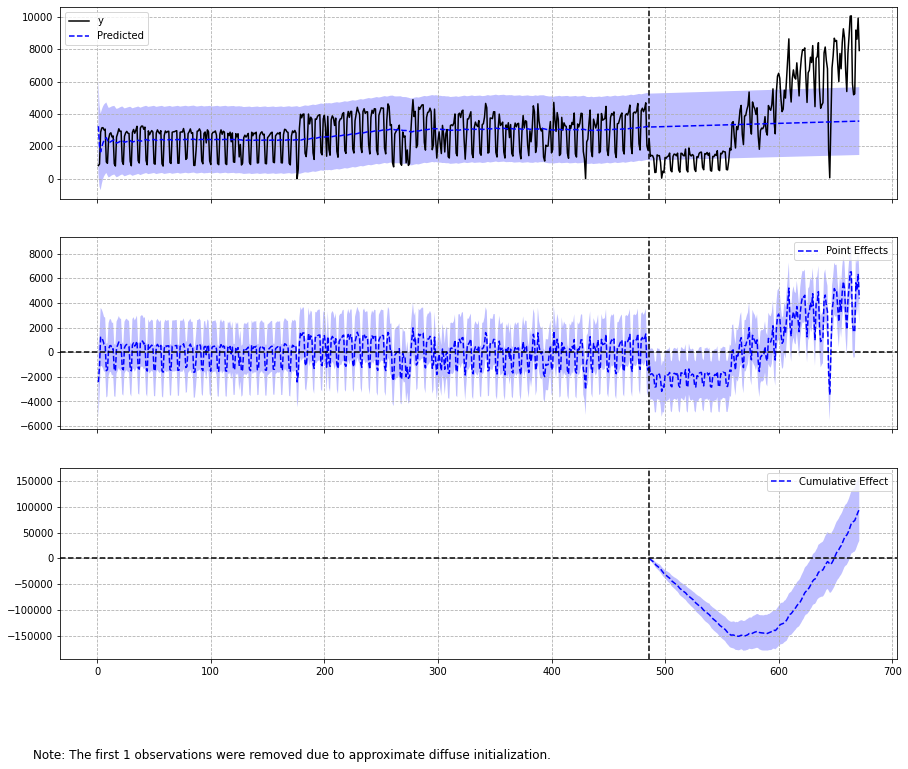

In [8]:
data = data_for_plot[['ID','index1']].copy()
pre_period = [0, 486]
post_period = [487, 671]

m1 = ci.CausalImpact(data, pre_period, post_period)
print(m1.summary())
print(m1.summary(output='report'))
m1.plot()

## Use hdbscan

In [ ]:
# all crashes past the inflection point
# join crash data to population data
# calculate crashes per 100K for each county
# create pivot with state, county in the rows and date in the columns
# with the crashes_per_100k as the values
# perform umap
# and then hdbscan
# take cluster list back to crashes, date, population
# calculate crashes_per_capita per cluster for each day
# plot pre intervention, 
# plot post intervention
# ( or perhaps skip the per capita thing completely?)

In [9]:
## need to make a dataset that I can use for clustering AND pycausalimpact...
# need to make sure those IDs are counted consistently!
data_for_cluster = crashes_subset[crashes_subset['Start_Date'] >= dt.date(2020,6,30)]
# pivot
data_pivot = data_for_cluster.pivot(index=['County','State'],columns='Start_Date',values='ID')
# fill missing
data_pivot = data_pivot.fillna(0)

## Unsupervised Learning with UMAP / HDBSCAN

In [10]:
def plot_embedding(embeddings, scores):
    # custom color mapping
    cdict = {'red': ((0.0, 0.0, 0.0),
             (0.1, 0.5, 0.5),
             (0.2, 0.0, 0.0),
             (0.4, 0.2, 0.2),
             (0.6, 0.0, 0.0),
             (0.8, 1.0, 1.0),
             (1.0, 1.0, 1.0)),
    'green':((0.0, 0.0, 0.0),
             (0.1, 0.0, 0.0),
             (0.2, 0.0, 0.0),
             (0.4, 1.0, 1.0),
             (0.6, 1.0, 1.0),
             (0.8, 1.0, 1.0),
             (1.0, 0.0, 0.0)),
    'blue': ((0.0, 0.0, 0.0),
             (0.1, 0.5, 0.5),
             (0.2, 1.0, 1.0),
             (0.4, 1.0, 1.0),
             (0.6, 0.0, 0.0),
             (0.8, 0.0, 0.0),
             (1.0, 0.0, 0.0))}
    my_cmap = LinearSegmentedColormap('my_colormap',cdict,256)
    # create subplot
    fig, axes = plt.subplots(nrows=1, figsize=(10,7))
    plt.scatter(embeddings[:,0], embeddings[:,1], s=3, cmap=my_cmap, c=scores.labels_, alpha=0.55)

In [11]:
# convert to numpy array
np_arr = data_pivot.to_numpy()
# use UMAP to create embeddings
reducer = umap.UMAP(n_neighbors=100, random_state=100)
embeddings = reducer.fit_transform(np_arr)
# create clusters via hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=30)
scores = hdb.fit(embeddings)

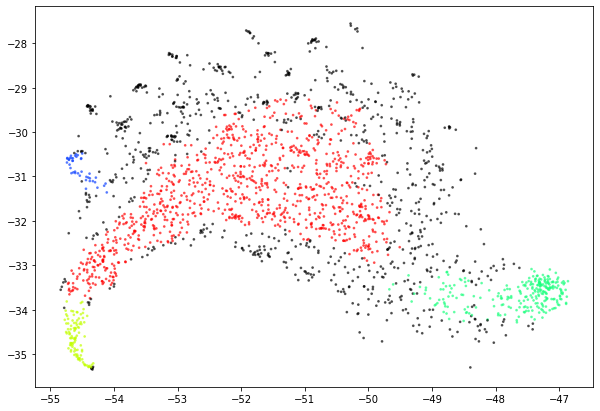

In [12]:
# plot the clusters on the embeddings
plot_embedding(embeddings, scores)
# there are 5 difference clusters 
# np.max(scores.labels_)

<AxesSubplot:ylabel='$\\lambda$ value'>

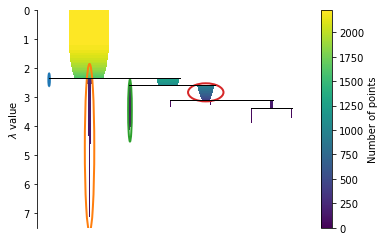

In [13]:
# plot the lambda measure
scores.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [14]:
# guess I have to reset the index first?
data_pivot = data_pivot.reset_index()
# append the clusters back to the dataframea
data_pivot['Clusters'] = scores.labels_
crashes_cluster = data_pivot.melt(id_vars=['County','State','Clusters'])
# reduce duplicates or else they will show up in the join
crashes_cluster = crashes_cluster[['County','State','Clusters']].drop_duplicates()

## Plot Clustered Counts

In [15]:
# now I have to merge the clusters back onto the full time period
data_for_plot2 = pd.merge(
    left=crashes_subset,
    right=crashes_cluster[['County','State','Clusters']],
    how="left",
    on=['County','State']
)

In [16]:
# data for plot
data_for_plot2 = data_for_plot2[data_for_plot2['Clusters'] > -1].groupby(['Clusters','Start_Date']).agg({'ID':'sum'})
data_for_plot2 = data_for_plot2.reset_index()
# create a day_value column which starts counting at the beginning of the period, March 1st
data_for_plot2['Min_Day'] = '2019-03-01'
data_for_plot2[['Start_Date','Min_Day']] = data_for_plot2[['Start_Date','Min_Day']].apply(pd.to_datetime)
data_for_plot2['Day_Value'] = (data_for_plot2['Start_Date'] - data_for_plot2['Min_Day']).dt.days

In [17]:
from plotnine import geom_line, ggtitle

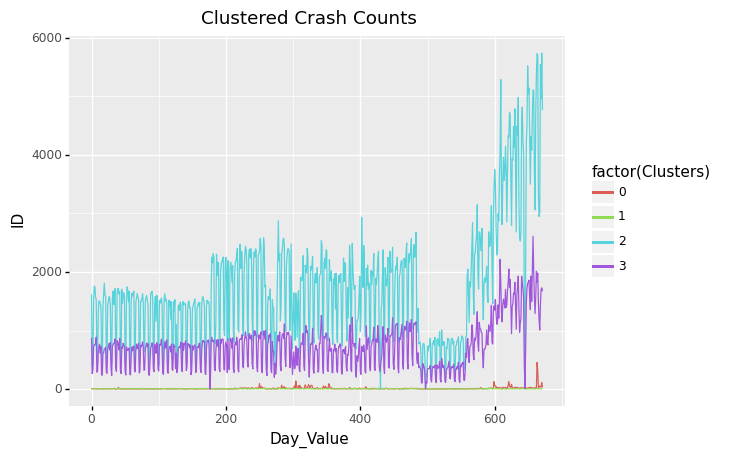

<ggplot: (8771444257521)>

In [18]:
(
    ggplot(data_for_plot2, aes('Day_Value','ID',color='factor(Clusters)'))
    + geom_line()
    + ggtitle('Clustered Crash Counts')
)

## Perhaps I should calculate the crashes per capita?
( not quite as interesting ... and somewhat besides the point because I've already seen that the counts have increased quite a bit over what was expected )

In [19]:
# load population data
pop_df = pd.read_csv('/home/gopherguy14/datasets/covid_county_population.csv', engine='python')
# create a county variable without the word 'county'
pop_df['County'] = pop_df['County Name'].str.split(' ',expand=True)[0]
# filter out the 'statewide' category
pop_df = pop_df[ pop_df['County'] != 'Statewide']
# drop old county name column
pop_df = pop_df.drop(columns=['County Name','countyFIPS'])
# drop duplicates just in case
pop_df = pop_df.drop_duplicates()

In [20]:
cluster_pop = pd.merge(
    left=crashes_cluster,
    right=pop_df,
    how="left",
    on=['State','County']
) 

In [21]:
crashes_pop = pd.merge(
    left=crashes_subset,
    right=cluster_pop,
    how="left",
    on=['State','County']
) 

In [22]:
crashes_pop.to_csv(path_or_buf="./data_for_tableau.csv",index=False)

In [23]:
# create dataset for plot
data_for_plot3 = crashes_pop.groupby(['Clusters','Start_Date']).agg({'ID':'sum','population':'sum'})
data_for_plot3 = data_for_plot3.reset_index()
# calculate crashes per capita
data_for_plot3['crashes_per_capita'] = ( data_for_plot3['ID'] / data_for_plot3['population'] ) * 100000
# create a day_value column which starts counting at the beginning of the period, March 1st
data_for_plot3['Min_Day'] = '2019-03-01'
data_for_plot3[['Start_Date','Min_Day']] = data_for_plot3[['Start_Date','Min_Day']].apply(pd.to_datetime)
data_for_plot3['Day_Value'] = (data_for_plot3['Start_Date'] - data_for_plot3['Min_Day']).dt.days
# filter to just the 2,3 clusters
data_for_plot3 = data_for_plot3[data_for_plot3['Clusters'] > 1.0]

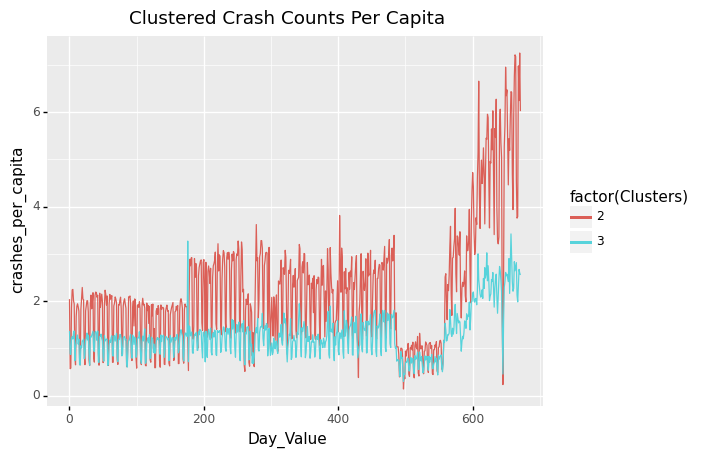

<ggplot: (8771520211945)>

In [24]:
(
    ggplot(data_for_plot3, aes('Day_Value','crashes_per_capita',color='factor(Clusters)'))
    + geom_line()
    + ggtitle('Clustered Crash Counts Per Capita')
)

## Plot population distribution per clusters 2, 3
Seems to be that the average population per county for Cluster 3 is larger than the average population per county for Cluster 2. This fact, in addition to the fact that counties in Cluster 2 exhibit a higher crash rate per capita, suggests that risk increases at a greater rate than can be explained by a linear relation. 

In [50]:
data_for_plot4 = cluster_pop.dropna(axis=0).copy()

In [51]:
data_for_plot4 = data_for_plot4[data_for_plot4['Clusters'] > 1]

In [52]:
data_for_plot4['poplog10'] = np.log10(data_for_plot4['population'])

In [44]:
from plotnine import geom_histogram, geom_density

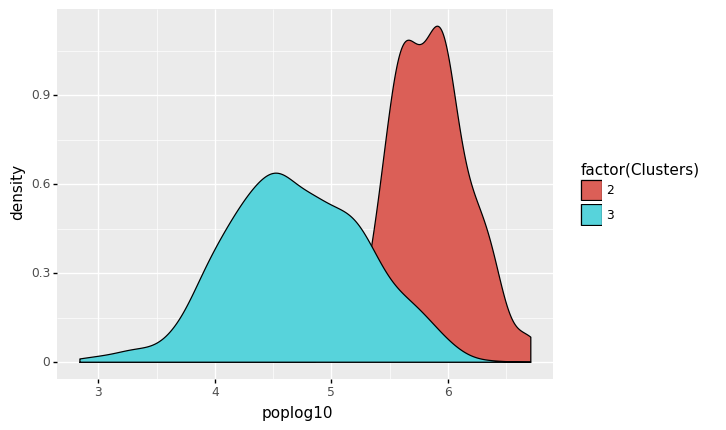

<ggplot: (8771609853301)>

In [53]:
(
    ggplot(data=data_for_plot4) 
    + aes(x='poplog10', fill='factor(Clusters)')
    + geom_density()
)

## Perform Logistic Regression?

I guess the reponse variable could be the crash rate. But since I've spent so much effort with the clustering, 
shouldn't the cluster category be the target? 

I think it would be wrong to set the 'clusters' as a predictor. Should probably do logistic regression or use the logistic objective function in xgboost. hmmm

And what should the time period be? I have steady state, and then I have covid. I can calculate the covid per capita rate, and the crash per capita rate, and a few other factors and see what I get. 

I think I will ignore the natural langauge processing bit. 

In [ ]:
# create subset of data to show to be one year prior to March 12th, 2020 and
# up to December 31st, 2020 
crashes_subset = crashes_df[ ( crashes_df['Start_Time'] > '2019-03-01' ) & ( crashes_df['Start_Time'] < '2021-01-01') ][['ID','Start_Date','County','State']]
# remove duplicates
crashes_subset = crashes_subset.drop_duplicates(subset='ID')
# perform the aggregation
crashes_subset = crashes_subset.groupby(['Start_Date','County','State']).agg({'ID':'count'})
crashes_subset = crashes_subset.reset_index()

In [64]:
len(crashes_df.columns)

50

In [62]:
crashes_df['Description']

0          Right lane blocked due to accident on I-70 Eas...
1          Accident on Brice Rd at Tussing Rd. Expect del...
2          Accident on OH-32 State Route 32 Westbound at ...
3          Accident on I-75 Southbound at Exits 52 52B US...
4          Accident on McEwen Rd at OH-725 Miamisburg Cen...
                                 ...                        
4232536                             At Market St - Accident.
4232537      At Camino Del Rio/Mission Center Rd - Accident.
4232538    At Glassell St/Grand Ave - Accident. in the ri...
4232539       At CA-90/Marina Fwy/Jefferson Blvd - Accident.
4232540                At Highland Ave/Arden Ave - Accident.
Name: Description, Length: 4232541, dtype: object

In [56]:
crashes_subset.head()

,Start_Date,County,State,ID
0,2019-03-01,Accomack,VA,1
1,2019-03-01,Adams,CO,8
2,2019-03-01,Aiken,SC,2
3,2019-03-01,Alachua,FL,2
4,2019-03-01,Alameda,CA,26


In [55]:
crashes_cluster

,County,State,Clusters
0,Abbeville,SC,3
1,Acadia,LA,1
2,Accomack,VA,3
3,Ada,ID,3
4,Adair,IA,-1
...,...,...,...
2219,York,VA,3
2220,Young,TX,-1
2221,Yuba,CA,3
2222,Yuma,AZ,3


In [54]:
cluster_pop.head()

,County,State,Clusters,population
0,Abbeville,SC,3,24527.0
1,Acadia,LA,1,62045.0
2,Accomack,VA,3,32316.0
3,Ada,ID,3,481587.0
4,Adair,IA,-1,7152.0


## Delete Me (Eventually)

In [3]:
covid_df = pd.read_csv('/home/gopherguy14/datasets/covid_confirmed_usafacts.csv')
pop_df = pd.read_csv('/home/gopherguy14/datasets/covid_county_population.csv', engine='python')

In [4]:
# select the id columns
id_vars = covid_df.columns[:4]
# select only the date columns
value_vars = covid_df.columns[4:]
# melt the covid data
covid_melt_df = pd.melt(covid_df, id_vars=id_vars, value_vars=value_vars)
# find new cases by sorting
covid_melt_df = covid_melt_df.sort_values(by=['countyFIPS','variable'])
# then grouping and subtracting each successive date from the next
covid_melt_df['new_cases'] = covid_melt_df.groupby(['countyFIPS'])['value'].diff().fillna(0)
# merge the covid data with the population data
usafacts_data = pd.merge(
    left=covid_melt_df, 
    right=pop_df[['countyFIPS','State','population']],
    how="left",
    on=['countyFIPS','State']
)
# remove 'statewide unallocated' from County Name
usafacts_data = usafacts_data.drop(usafacts_data[usafacts_data['County Name'] == 'Statewide Unallocated'].index)
# drop StateFIPS, value
usafacts_data = usafacts_data.drop(['countyFIPS','StateFIPS','value'],axis=1)
# rename variable to 'covid_date'
usafacts_data = usafacts_data.rename(columns={'variable':'covid_date'})
# create a county variable without the word 'county'
usafacts_data['County'] = usafacts_data['County Name'].str.split(' ',expand=True)[0]

In [6]:
# load crash data into dataframe
crashes_df = pd.read_csv('/home/gopherguy14/datasets/US_Accidents_Dec20.csv')
# convert start_time to datetime and save date component into new column
crashes_df['Start_Date'] = crashes_df['Start_Time'].astype("datetime64[ns]").dt.date
# drop old county name column
usafacts_data = usafacts_data.drop(columns='County Name')